In [29]:
import numpy as np
import networkx as nx
import synthetic
from sharetrace import propagation, search
from evaluation import synthetic
from matplotlib import pyplot as plt
import json
import pandas as pd
import os
from scipy import optimize
import seaborn as sns
import matplotlib
import pymetis

In [2]:
DATA_DIR = './/data'
LOGS_DIR = './/logs'
COLORS = np.array(['#ff304f', '#002651', '#775ada', '#28c7fa'])
CS = 'contact-search'
SERIAL = 'risk-propagation:serial'
LEWICKI = 'risk-propagation:lewicki'
RAY = 'risk-propagation:ray'
TOL = 'risk-propagation:tolerance'

In [3]:
def load_results(name: str):
    def parse(line):
        return json.loads(line.split('|')[-1])

    log = os.path.join(LOGS_DIR, f'{name}.log')
    with open(log, 'r') as f:
        if name in (RAY, TOL):
            exposures, results = [], []
            line, is_results = f.readline(), True
            while line:
                line = parse(line)
                if is_results:
                    results.append(line)
                    is_results = False
                else:
                    escores = np.array(line['ExposureScores'])
                    exposures.append(escores)
                    is_results = True
                line = f.readline()
            rgroups = [[] for _ in range(3)]
            egroups = [[] for _ in range(3)]
            for i, (r, e) in enumerate(zip(results, exposures)):
                rgroups[i % 3].append(r)
                egroups[i % 3].append(e)
            results = (rgroups, egroups)
        else:
            results = [parse(line) for line in f.readlines()]
        return results

def load_data(n, parts=1, return_graph=False):
    scores = synthetic.load_scores(n)
    contacts = synthetic.load_contacts(n)
    if return_graph:
        rp = propagation.RiskPropagation(workers=parts)
        graph, _, labels = rp.create_graph(scores, contacts)
        adj = adj_mat(graph, rp.nodes)
        return scores, contacts, graph, labels, adj
    else:
        return scores, contacts

## Contact search

In [4]:
def plot_contact_search_runtime(results, fname=None):
    users = np.arange(1000, 11000, 1000)
    times = np.array([r['RuntimeInSeconds'] for r in results])

    plt.plot(users, times, '-o')
    plt.xlabel('Number of users')
    plt.ylabel('Runtime (s)')

    if fname is not None:
        plt.savefig(fname, dpi=400)
        
def fit_contact_search_runtime(results):
    # Reference: https://stackoverflow.com/a/2142113
    def func(x, a, c, d):
        return a*np.exp(c*x)+d

    times = np.array([r['RuntimeInSeconds'] for r in results])
    users = np.arange(1000, 11000, 1000)
    popt, pcov = optimize.curve_fit(func, users, times, p0=(1, 1e-6, 1))
    perr = np.sqrt(np.diag(pcov))

    xx = np.linspace(1000, 10000, 1000)
    yy = func(xx, *popt)
    
    return (popt, pcov, perr), (users, times), (xx, yy)

In [41]:
cs = load_results(CS)

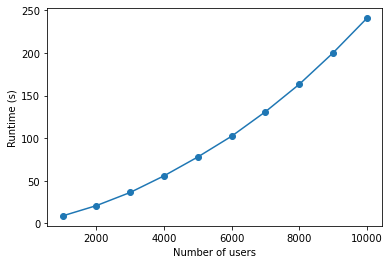

In [42]:
plot_contact_search_runtime(cs, fname='cs-runtimes.png')

In [7]:
(popt, _, perr), _, _ = fit_contact_search_runtime(cs)
(a, c, d), (aerr, cerr, derr) = popt, perr
print('params:', f'coefficent={round(a, 4)}, exp power={round(c, 4)}, additive constant={round(d, 4)}')
print('errs:', f'coefficent={round(aerr, 4)}, exp power={round(cerr, 8)}, additive constant={round(derr, 4)}')

params: coefficent=86.0569, exp power=0.0001, additive constant=-91.3174
errs: coefficent=4.2912, exp power=3.61e-06, additive constant=5.1328


## Risk propagation

In [5]:
def adj_mat(graph, n_nodes):
    adj = np.zeros((n_nodes,n_nodes))
    for (n1, n2) in (e for e in graph if isinstance(e, tuple)):
        adj[n1][n2] = 1
    return adj

def plot_graph(adj, labels, colors=COLORS, fname=None):
    f = plt.figure()
    network = nx.from_numpy_array(adj)
    if colors is None:
        nx.draw(network, node_size=5, ax=f.add_subplot(111))
    else:
        nx.draw(network, node_color=colors[labels], node_size=5, ax=f.add_subplot(111))
    if fname is not None:
        f.savefig(fname, dpi=400, bbox_inches='tight')

def get_graph_sizes(results):
    nodes = np.array([r['Nodes'] for r in results])
    edges = np.array([r['Edges'] for r in results])
    return nodes, edges

def plot_graph_sizes(nodes, edges, fname=None):
    runs = np.arange(1000, 1000 * (len(nodes) + 1), 1000)
    plt.plot(runs, nodes, '-o');
    plt.plot(runs, edges, '-x');
    plt.legend(['Nodes', 'Edges'])
    plt.xlabel('Number of users')
    plt.ylabel('Amount')
    if fname is not None:
        plt.savefig(fname, dpi=400)

def get_risk_prop_runtimes(results, nested=False):
    def get(res):
        runs = (r['WorkerLogs'] for r in res)
        return np.array([max(w['RuntimeInSec'] for w in r) for r in runs])
    if nested:
        times = [get(r) for r in results]
    else:
        times = get(results)
    return times

def plot_risk_prop_runtimes(stimes, rtimes, edges, fname=None):
    plt.plot(edges, stimes)
    for i in range(3):
        plt.plot(edges, rtimes[i])
    plt.xlabel('Edges')
    plt.ylabel('Runtime (s)')
    plt.legend([f'{n + 1} actors' for n in range(4)])
    if fname is not None:
        plt.savefig(fname, dpi=400)

def plot_kde(scores, exposures, n):
    symptoms = propagation.initial(scores.T)['val']
    sns.kdeplot(symptoms[:n * 1000])
    sns.kdeplot(exposures[0][n])
    plt.legend(['Symptom scores', 'Exposure scores']);

In [37]:
serial = load_results(SERIAL)
ray, exposures = load_results(RAY)

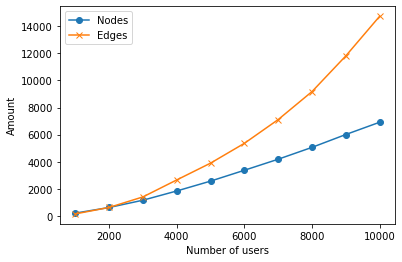

In [38]:
nodes, edges = get_graph_sizes(serial)
plot_graph_sizes(nodes, edges, 'graph-sizes.png')

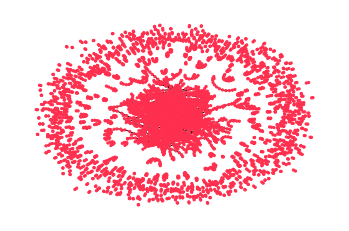

In [23]:
_, _, _, labels, adj = load_data(10000, parts=1, return_graph=True)
plot_graph(adj, labels, 'graph-10k-1')

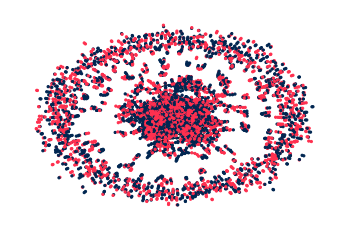

In [24]:
_, _, _, labels, adj = load_data(10000, parts=2, return_graph=True)
plot_graph(adj, labels, 'graph-10k-2')

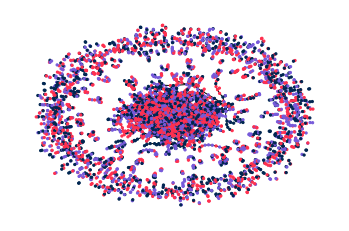

In [25]:
_, _, _, labels, adj = load_data(10000, parts=3, return_graph=True)
plot_graph(adj, labels, 'graph-10k-3')

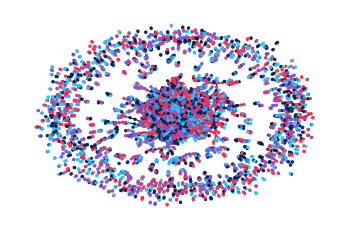

In [26]:
_, _, _, labels, adj = load_data(10000, parts=4, return_graph=True)
plot_graph(adj, labels, 'graph-10k-4')

In [15]:
stimes = get_risk_prop_runtimes(serial)
rtimes = get_risk_prop_runtimes(ray, nested=True)

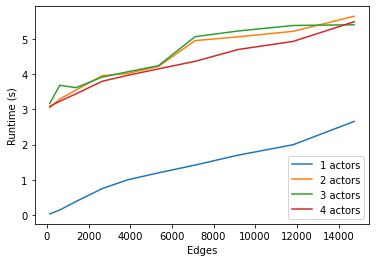

In [39]:
plot_risk_prop_runtimes(stimes, rtimes, edges, 'rp-runtimes.png')

In [25]:
data = synthetic.create_data(1000)
scores, hists = data.scores, data.geohashes()

In [26]:
cs = search.ContactSearch(min_dur=15, workers=-1)
contacts = cs.search(hists)

In [27]:
rp = propagation.RiskPropagation(workers=2)

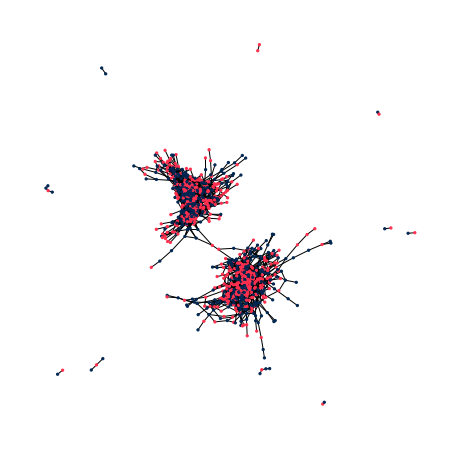

In [28]:
matplotlib.rcParams['figure.figsize'] = (8,8)
graph, _, labels = rp.create_graph(scores, contacts)
adj = adj_mat(graph, rp.nodes)
plot_graph(adj, labels, fname='bipartite.png')